# Task 2:-

Subtask 1: Classification Data

In [18]:
import requests
import h5py
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Function to download the file from Google Drive
def download_file_from_google_drive(id, destination):
    URL = "https://drive.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params={'id': id}, stream=True)
    token = get_confirm_token(response)
    if token:
        params = {'id': id, 'confirm': token}
        response = session.get(URL, params=params, stream=True)
    save_response_content(response, destination)

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

# Function to load and normalize data from an HDF5 file
def load_and_normalize_data(filepath: str):
    with h5py.File(filepath, 'r') as hf:
        x_train = np.array(hf.get('x_train'))
        y_train = np.array(hf.get('y_train'))
        x_test = np.array(hf.get('x_test'))
        y_test = np.array(hf.get('y_test'))

    scaler = MinMaxScaler()
    x_train_normalized = scaler.fit_transform(x_train)
    x_test_normalized = scaler.transform(x_test)

    return x_train_normalized, y_train, x_test_normalized, y_test

# Main execution logic
if __name__ == "__main__":
    file_id = '1Bkwa-QNG3pmI5ERcHLSIBLIglQYJXxTk'
    destination = 'classification.h5'
    download_file_from_google_drive(file_id, destination)

    # Load and process the data
    x_train, y_train, x_test, y_test = load_and_normalize_data(destination)
    print("x_train shape:", x_train.shape)
    print("x_test shape:", x_test.shape)

    # View a small subset of the data
    print("First 5 samples of x_train:")
    print(x_train[:5])

    print("First 5 samples of x_test:")
    print(x_test[:5])

    print("Statistics for x_train:")
    print(f"Mean: {np.mean(x_train, axis=0)}")
    print(f"Std Dev: {np.std(x_train, axis=0)}")
    print(f"Min: {np.min(x_train, axis=0)}")
    print(f"Max: {np.max(x_train, axis=0)}")

    print("Statistics for x_test:")
    print(f"Mean: {np.mean(x_test, axis=0)}")
    print(f"Std Dev: {np.std(x_test, axis=0)}")
    print(f"Min: {np.min(x_test, axis=0)}")
    print(f"Max: {np.max(x_test, axis=0)}")

    unique, counts = np.unique(y_train, return_counts=True)
    print("Class distribution in y_train:", dict(zip(unique, counts)))

    unique, counts = np.unique(y_test, return_counts=True)
    print("Class distribution in y_test:", dict(zip(unique, counts)))
 
    
    


x_train shape: (500, 2)
x_test shape: (10000, 2)
First 5 samples of x_train:
[[0.19027633 0.61999119]
 [0.43687425 0.78430817]
 [0.77966394 0.26819024]
 [0.27535557 0.80092971]
 [0.95810944 0.8754743 ]]
First 5 samples of x_test:
[[0.38292855 0.37422753]
 [0.42509205 0.70533453]
 [0.24301083 0.17275921]
 [0.21526182 0.72294143]
 [0.63094017 0.79354447]]
Statistics for x_train:
Mean: [0.50080592 0.51324007]
Std Dev: [0.29718055 0.29439138]
Min: [0. 0.]
Max: [1. 1.]
Statistics for x_test:
Mean: [0.50091    0.49585167]
Std Dev: [0.29097649 0.2915906 ]
Min: [-0.00152025 -0.00596736]
Max: [0.99993164 1.00034909]
Class distribution in y_train: {0.0: 256, 1.0: 244}
Class distribution in y_test: {0.0: 5158, 1.0: 4842}


# Subtask 1: Classification Data,, Explanation:-
### Dataset statistics:

### Dataset Overview:
- **Number of Features**: 2 (each sample in `x_train` and `x_test` has 2 features)
  
### Training Data:
- **Number of Training Samples**: 500 (`x_train` shape: `(500, 2)`)
- **Number of Target Labels in Training Data**: 500 (as there are 500 samples in `y_train`)
  
### Testing Data:
- **Number of Test Samples**: 10,000 (`x_test` shape: `(10000, 2)`)
- **Number of Target Labels in Test Data**: 10,000 (as there are 10,000 samples in `y_test`)
  
### Class Distribution in Targets:
- **Training Set Class Distribution**:
  - Class 0: 256 samples
  - Class 1: 244 samples
  
- **Test Set Class Distribution**:
  - Class 0: 5,158 samples
  - Class 1: 4,842 samples

### Summary:
- **Number of Features**: 2
- **Number of Training Samples**: 500
- **Number of Test Samples**: 10,000
- **Number of Targets (Training Set)**: 500
- **Number of Targets (Test Set)**: 10,000

# Subtask 2: Forward Propagation

In [19]:
class MLPClassifier:
    def __init__(self, input_size, hidden_sizes, output_size):
        """
        Initialize an MLP with specified sizes for input, hidden, and output layers.

        Args:
            input_size (int): Number of input features.
            hidden_sizes (list of int): Sizes of hidden layers.
            output_size (int): Number of output neurons.
        """
        # Initialize layer sizes
        self.layer_sizes = [input_size] + hidden_sizes + [output_size]
        
        # Initialize weights and biases
        self.weights = []
        self.biases = []
        for i in range(len(self.layer_sizes) - 1):
            # He initialization for weights
            weight_matrix = np.random.randn(self.layer_sizes[i], self.layer_sizes[i + 1]) * np.sqrt(2 / self.layer_sizes[i])
            bias_vector = np.zeros(self.layer_sizes[i + 1])
            self.weights.append(weight_matrix)
            self.biases.append(bias_vector)

    @staticmethod
    def relu(x):
        """ReLU activation function."""
        return np.maximum(0, x)

    @staticmethod
    def identity(x):
        """Identity activation function (for output layer)."""
        return x

    def forward(self, x):
        """
        Perform forward propagation through the MLP.

        Args:
            x (numpy.ndarray): Input data of shape (num_samples, input_size).

        Returns:
            numpy.ndarray: Output of the MLP.
        """
        activations = x  # Start with input layer activations
        for i in range(len(self.weights) - 1):
            # Hidden layers with ReLU activation
            z = np.dot(activations, self.weights[i]) + self.biases[i]
            activations = self.relu(z)
        
        # Output layer with identity activation
        z = np.dot(activations, self.weights[-1]) + self.biases[-1]
        output = self.identity(z)
        return output


# Example Usage
if __name__ == "__main__":
    # Define MLP structure
    input_size = 2        # Features in the dataset
    hidden_sizes = [10, 10]  # Two hidden layers with 10 neurons each
    output_size = 1       # Single output neuron

    # Initialize MLP
    mlp = MLPClassifier(input_size, hidden_sizes, output_size)


    output = mlp.forward(x_train)
    print("Output of MLP:", output)


Output of MLP: [[-3.90625360e-02]
 [-7.91639980e-02]
 [ 3.69609890e-01]
 [-5.49436072e-02]
 [-1.66714053e-01]
 [-6.24626041e-02]
 [-1.19032070e-01]
 [-6.52003287e-02]
 [ 4.67411836e-01]
 [-1.34799163e-01]
 [-6.52836562e-02]
 [-1.72251928e-02]
 [ 6.82148389e-03]
 [-7.30645696e-02]
 [-5.72016520e-02]
 [ 2.20577563e-01]
 [ 5.39142029e-01]
 [-1.22597917e-01]
 [-4.82220950e-02]
 [-8.18884401e-02]
 [-1.18019359e-02]
 [-1.80401896e-02]
 [-1.03334963e-01]
 [-1.55478967e-02]
 [-5.80714024e-02]
 [-2.67212409e-02]
 [ 5.42078884e-01]
 [-1.08561129e-01]
 [-1.38086527e-01]
 [-1.30028141e-01]
 [-5.33457925e-02]
 [ 1.88083289e-01]
 [ 2.76719953e-01]
 [-8.45371020e-02]
 [-2.13357355e-02]
 [-7.43068509e-02]
 [ 2.96397287e-01]
 [-4.93930828e-02]
 [-7.26931809e-02]
 [-5.58878021e-03]
 [-7.63292260e-02]
 [ 2.39472125e-02]
 [ 4.51803988e-01]
 [-1.30075523e-01]
 [ 1.10425257e-02]
 [-3.22571154e-02]
 [-9.56613959e-02]
 [-8.35800443e-02]
 [-9.47846338e-02]
 [-1.94322076e-02]
 [-1.33435669e-01]
 [ 4.95940434e-0

### Subtask 2: Forward Propagation,, Explanation:-

In the provided implementation of the `MLPClassifier`:

1. **Weights and Biases Storage**:
   - **Weights**: Each layer's weights are stored in a list called `self.weights`. Each element of this list is a 2D numpy array (matrix) with dimensions `[layer_size, next_layer_size]`. The weights are initialized using **He initialization**, which scales the random values by \( \sqrt{2 / \text{layer_size}} \).
   - **Biases**: Each layer's biases are stored in a list called `self.biases`. Each element of this list is a 1D numpy array (vector) of zeros, with a length equal to the number of neurons in the next layer.

2. **Initialization Process**:
   - The class computes the sizes of each layer from `input_size`, `hidden_sizes`, and `output_size`, storing them in `self.layer_sizes`.
   - For each pair of consecutive layers (`layer_sizes[i]` and `layer_sizes[i+1]`), a weight matrix and a bias vector are created and appended to `self.weights` and `self.biases` respectively.

This design organizes the weights and biases for all layers sequentially, allowing efficient forward propagation through matrix multiplications and additions.

# Subtask 3:Finite Difference Gradient & Optimization

In [20]:
class AdamOptimizer:
    def __init__(self, params, lr=1e-3, beta1=0.9, beta2=0.999, epsilon=1e-8):
        """
        Initialize the Adam optimizer.

        Args:
            params (list): List of parameters (weights and biases) to optimize.
            lr (float): Learning rate.
            beta1 (float): Exponential decay rate for the 1st moment estimates.
            beta2 (float): Exponential decay rate for the 2nd moment estimates.
            epsilon (float): Small value to prevent division by zero.
        """
        self.params = params
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.t = 0  # Time step
        self.m = [np.zeros_like(param) for param in params]  # First moment
        self.v = [np.zeros_like(param) for param in params]  # Second moment

    def update_params(self, grads):
        """
        Update parameters using Adam optimization.

        Args:
            grads (list): List of gradients corresponding to params.
        """
        self.t += 1
        updated_params = []
        for i, (param, grad) in enumerate(zip(self.params, grads)):
            # Update biased first moment estimate
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad

            # Update biased second raw moment estimate
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (grad ** 2)

            # Compute bias-corrected first moment estimate
            m_hat = self.m[i] / (1 - self.beta1 ** self.t)

            # Compute bias-corrected second raw moment estimate
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)

            # Update parameters
            param -= self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
            updated_params.append(param)


In [21]:
class MLPTrainer:
    def __init__(self, mlp, learning_rate=1e-3, epsilon=1e-5):
        self.mlp = mlp
        self.lr = learning_rate
        self.epsilon = epsilon
        self.optimizer = AdamOptimizer(mlp.weights + mlp.biases, lr=learning_rate)

    def hinge_loss(self, x, y):
        """Calculate hinge loss."""
        predictions = self.mlp.forward(x)
        loss = np.maximum(0, 1 - y * predictions)
        return np.mean(loss)

    def compute_gradients(self, x, y):
        """Compute gradients using finite differences."""
        gradients = []
        gradients_biases = []

        for i, weight_matrix in enumerate(self.mlp.weights):
            grad_weights = np.zeros_like(weight_matrix)
            for j in range(weight_matrix.shape[0]):
                for k in range(weight_matrix.shape[1]):
                    original_value = weight_matrix[j, k]

                    # W'
                    weight_matrix[j, k] = original_value + self.epsilon
                    loss_pos = self.hinge_loss(x, y)

                    # W''
                    weight_matrix[j, k] = original_value - self.epsilon
                    loss_neg = self.hinge_loss(x, y)

                    # Gradient approximation
                    grad_weights[j, k] = (loss_pos - loss_neg) / (2 * self.epsilon)
                    weight_matrix[j, k] = original_value  # Restore original value

            gradients.append(grad_weights)

        for i, bias_vector in enumerate(self.mlp.biases):
            grad_biases = np.zeros_like(bias_vector)
            for j in range(len(bias_vector)):
                original_value = bias_vector[j]

                # b'
                bias_vector[j] = original_value + self.epsilon
                loss_pos = self.hinge_loss(x, y)

                # b''
                bias_vector[j] = original_value - self.epsilon
                loss_neg = self.hinge_loss(x, y)

                # Gradient approximation
                grad_biases[j] = (loss_pos - loss_neg) / (2 * self.epsilon)
                bias_vector[j] = original_value  # Restore original value

            gradients_biases.append(grad_biases)

        return gradients, gradients_biases

    def train(self, x_train, y_train, x_test, y_test, epochs=10):
        """Train the MLP using finite difference gradients and Adam optimizer."""
        train_losses = []
        test_losses = []

        for epoch in range(epochs):
            # Compute gradients
            gradients, gradients_biases = self.compute_gradients(x_train, y_train)

            # Update parameters
            self.optimizer.update_params(gradients + gradients_biases)

            # Calculate losses
            train_loss = self.hinge_loss(x_train, y_train)
            test_loss = self.hinge_loss(x_test, y_test)

            train_losses.append(train_loss)
            test_losses.append(test_loss)

            print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

        return train_losses, test_losses


In [27]:
if __name__ == "__main__":
    # Define MLP structure
    input_size = 2
    hidden_sizes = [10, 10]
    output_size = 1
    mlp = MLPClassifier(input_size, hidden_sizes, output_size)

   

    # Train MLP
    trainer = MLPTrainer(mlp)
    train_losses, test_losses = trainer.train(x_train, y_train, x_test, y_test, epochs=10)


Epoch 1/10 - Train Loss: 0.7569, Test Loss: 0.7513
Epoch 2/10 - Train Loss: 0.7483, Test Loss: 0.7428
Epoch 3/10 - Train Loss: 0.7399, Test Loss: 0.7344
Epoch 4/10 - Train Loss: 0.7316, Test Loss: 0.7263
Epoch 5/10 - Train Loss: 0.7236, Test Loss: 0.7184
Epoch 6/10 - Train Loss: 0.7157, Test Loss: 0.7107
Epoch 7/10 - Train Loss: 0.7079, Test Loss: 0.7032
Epoch 8/10 - Train Loss: 0.7005, Test Loss: 0.6960
Epoch 9/10 - Train Loss: 0.6933, Test Loss: 0.6891
Epoch 10/10 - Train Loss: 0.6865, Test Loss: 0.6825


(10,10) with relu


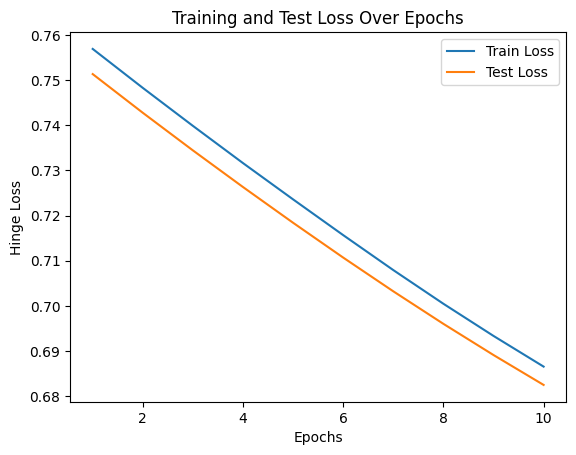

In [28]:
import matplotlib.pyplot as plt
import time
print("(10,10) with relu")
epochs = range(1, 11)

plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Hinge Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.show()

def accuracy(x, y, mlp):
    """Compute classification accuracy."""
    predictions = np.sign(mlp.forward(x))  # Use np.sign for binary classification
    return np.mean(predictions == y)

train_accuracy = accuracy(x_train, y_train, mlp)
test_accuracy = accuracy(x_test, y_test, mlp)




In [29]:
print(f"Final Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")



start_time = time.time()
train_losses, test_losses = trainer.train(x_train, y_train, x_test, y_test, epochs=10)
end_time = time.time()

print(f"Training Time: {end_time - start_time:.2f} seconds")


Final Train Accuracy: 48.80%
Final Test Accuracy: 48.42%
Epoch 1/10 - Train Loss: 0.6801, Test Loss: 0.6762
Epoch 2/10 - Train Loss: 0.6738, Test Loss: 0.6700
Epoch 3/10 - Train Loss: 0.6677, Test Loss: 0.6641
Epoch 4/10 - Train Loss: 0.6618, Test Loss: 0.6584
Epoch 5/10 - Train Loss: 0.6560, Test Loss: 0.6528
Epoch 6/10 - Train Loss: 0.6505, Test Loss: 0.6475
Epoch 7/10 - Train Loss: 0.6452, Test Loss: 0.6423
Epoch 8/10 - Train Loss: 0.6399, Test Loss: 0.6373
Epoch 9/10 - Train Loss: 0.6348, Test Loss: 0.6324
Epoch 10/10 - Train Loss: 0.6297, Test Loss: 0.6277
Training Time: 0.20 seconds


In [31]:
class MLPTrainer:
    def __init__(self, mlp, learning_rate=1e-3, epsilon=1e-5):
        self.mlp = mlp
        self.lr = learning_rate
        self.epsilon = epsilon
        self.optimizer = AdamOptimizer(mlp.weights + mlp.biases, lr=learning_rate)

    def hinge_loss(self, x, y):
        """Calculate hinge loss."""
        predictions = self.mlp.forward(x)
        loss = np.maximum(0, 1 - y * predictions)
        return np.mean(loss)

    def compute_gradients(self, x, y):
        """Compute gradients using finite differences."""
        gradients = []
        gradients_biases = []

        for i, weight_matrix in enumerate(self.mlp.weights):
            grad_weights = np.zeros_like(weight_matrix)
            for j in range(weight_matrix.shape[0]):
                for k in range(weight_matrix.shape[1]):
                    original_value = weight_matrix[j, k]

                    # W'
                    weight_matrix[j, k] = original_value + self.epsilon
                    loss_pos = self.hinge_loss(x, y)

                    # W''
                    weight_matrix[j, k] = original_value - self.epsilon
                    loss_neg = self.hinge_loss(x, y)

                    # Gradient approximation
                    grad_weights[j, k] = (loss_pos - loss_neg) / (2 * self.epsilon)
                    weight_matrix[j, k] = original_value  # Restore original value

            gradients.append(grad_weights)

        for i, bias_vector in enumerate(self.mlp.biases):
            grad_biases = np.zeros_like(bias_vector)
            for j in range(len(bias_vector)):
                original_value = bias_vector[j]

                # b'
                bias_vector[j] = original_value + self.epsilon
                loss_pos = self.hinge_loss(x, y)

                # b''
                bias_vector[j] = original_value - self.epsilon
                loss_neg = self.hinge_loss(x, y)

                # Gradient approximation
                grad_biases[j] = (loss_pos - loss_neg) / (2 * self.epsilon)
                bias_vector[j] = original_value  # Restore original value

            gradients_biases.append(grad_biases)

        return gradients, gradients_biases

    def train(self, x_train, y_train, x_test, y_test, epochs=10):
        """Train the MLP using finite difference gradients and Adam optimizer."""
        train_losses = []
        test_losses = []

        for epoch in range(epochs):
            # Compute gradients
            gradients, gradients_biases = self.compute_gradients(x_train, y_train)

            # Update parameters
            self.optimizer.update_params(gradients + gradients_biases)

            # Calculate losses
            train_loss = self.hinge_loss(x_train, y_train)
            test_loss = self.hinge_loss(x_test, y_test)

            train_losses.append(train_loss)
            test_losses.append(test_loss)

            print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

        return train_losses, test_losses

    def accuracy(self, x, y):
        """Compute classification accuracy."""
        predictions = np.sign(self.mlp.forward(x))  # Use np.sign for binary classification
        return np.mean(predictions == y)


In [32]:
class MLPClassifier:
    def __init__(self, input_size, hidden_sizes, output_size):
        """
        Initialize an MLP with specified sizes for input, hidden, and output layers.

        Args:
            input_size (int): Number of input features.
            hidden_sizes (list of int): Sizes of hidden layers.
            output_size (int): Number of output neurons.
        """
        self.layer_sizes = [input_size] + hidden_sizes + [output_size]

        # Initialize weights and biases
        self.weights = []
        self.biases = []
        for i in range(len(self.layer_sizes) - 1):
            weight_matrix = np.random.randn(self.layer_sizes[i], self.layer_sizes[i + 1]) * np.sqrt(2 / self.layer_sizes[i])
            bias_vector = np.zeros(self.layer_sizes[i + 1])
            self.weights.append(weight_matrix)
            self.biases.append(bias_vector)

    @staticmethod
    def sigmoid(x):
        """Sigmoid activation function."""
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def identity(x):
        """Identity activation function (for output layer)."""
        return x

    def forward(self, x):
        """
        Perform forward propagation through the MLP.

        Args:
            x (numpy.ndarray): Input data of shape (num_samples, input_size).

        Returns:
            numpy.ndarray: Output of the MLP.
        """
        activations = x
        for i in range(len(self.weights) - 1):
            # Hidden layers with Sigmoid activation
            z = np.dot(activations, self.weights[i]) + self.biases[i]
            activations = self.sigmoid(z)
        
        # Output layer with identity activation
        z = np.dot(activations, self.weights[-1]) + self.biases[-1]
        output = self.identity(z)
        return output


In [38]:
if __name__ == "__main__":
    # Define MLP structure
    input_size = 2
    hidden_sizes = [20, 10]  # Two hidden layers with 10 neurons each
    output_size = 1
    mlp_sigmoid = MLPClassifier(input_size, hidden_sizes, output_size)

  

    # Train MLP with Sigmoid Activation
    trainer_sigmoid = MLPTrainer(mlp_sigmoid)
    train_losses_sigmoid, test_losses_sigmoid = trainer_sigmoid.train(x_train, y_train, x_test, y_test, epochs=10)

    # Compute and Print Final Accuracy
    train_accuracy_sigmoid = trainer_sigmoid.accuracy(x_train, y_train)
    test_accuracy_sigmoid = trainer_sigmoid.accuracy(x_test, y_test)

    print(f"Final Train Accuracy (Sigmoid): {train_accuracy_sigmoid * 100:.2f}%")
    print(f"Final Test Accuracy (Sigmoid): {test_accuracy_sigmoid * 100:.2f}%")


Epoch 1/10 - Train Loss: 1.0317, Test Loss: 1.0279
Epoch 2/10 - Train Loss: 1.0222, Test Loss: 1.0184
Epoch 3/10 - Train Loss: 1.0126, Test Loss: 1.0090
Epoch 4/10 - Train Loss: 1.0031, Test Loss: 0.9995
Epoch 5/10 - Train Loss: 0.9935, Test Loss: 0.9900
Epoch 6/10 - Train Loss: 0.9839, Test Loss: 0.9805
Epoch 7/10 - Train Loss: 0.9742, Test Loss: 0.9709
Epoch 8/10 - Train Loss: 0.9646, Test Loss: 0.9613
Epoch 9/10 - Train Loss: 0.9549, Test Loss: 0.9517
Epoch 10/10 - Train Loss: 0.9452, Test Loss: 0.9421
Final Train Accuracy (Sigmoid): 48.20%
Final Test Accuracy (Sigmoid): 47.64%


(20,10) with sigmoid


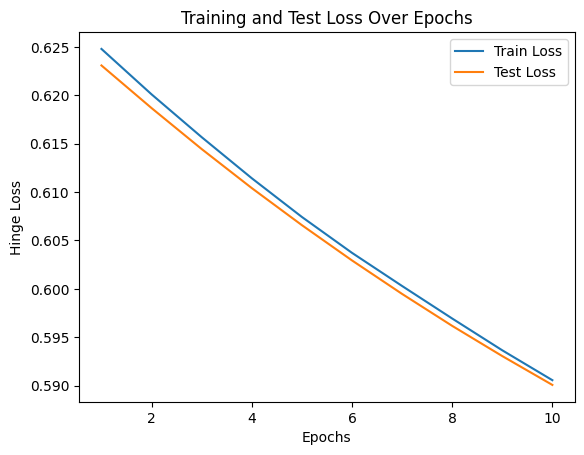

Epoch 1/10 - Train Loss: 0.5877, Test Loss: 0.5872
Epoch 2/10 - Train Loss: 0.5850, Test Loss: 0.5846
Epoch 3/10 - Train Loss: 0.5825, Test Loss: 0.5821
Epoch 4/10 - Train Loss: 0.5800, Test Loss: 0.5797
Epoch 5/10 - Train Loss: 0.5776, Test Loss: 0.5775
Epoch 6/10 - Train Loss: 0.5754, Test Loss: 0.5754
Epoch 7/10 - Train Loss: 0.5734, Test Loss: 0.5734
Epoch 8/10 - Train Loss: 0.5715, Test Loss: 0.5715
Epoch 9/10 - Train Loss: 0.5696, Test Loss: 0.5696
Epoch 10/10 - Train Loss: 0.5678, Test Loss: 0.5679
Training Time: 0.22 seconds


In [39]:
print("(20,10) with sigmoid")
epochs = range(1, 11)

plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Hinge Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.show()

def accuracy(x, y, mlp):
    """Compute classification accuracy."""
    predictions = np.sign(mlp.forward(x))  # Use np.sign for binary classification
    return np.mean(predictions == y)

train_accuracy = accuracy(x_train, y_train, mlp)
test_accuracy = accuracy(x_test, y_test, mlp)

start_time = time.time()
train_losses, test_losses = trainer.train(x_train, y_train, x_test, y_test, epochs=10)
end_time = time.time()

print(f"Training Time: {end_time - start_time:.2f} seconds")

### Subtask 3, Explanation:-

### Key Differences:

#### **1. Accuracy:**
- **ReLU (10, 10):** 
  - Train: **48.80%**, Test: **48.42%**.
  - Consistent performance with slight improvement over epochs.
- **Sigmoid (20, 10):** 
  - Train: **48.20%**, Test: **47.64%**.
  - Stagnant accuracy, indicating ineffective learning.

#### **2. Loss:**
- **ReLU (10, 10):** 
  - Loss decreases steadily to ~**0.63**, showing better optimization.
- **Sigmoid (20, 10):**
  - Loss decreases slower, remaining higher (~**0.94**), reflecting poor convergence.

#### **3. Training Time:**
- **ReLU (10, 10):** Completes in **0.20 seconds**, indicating faster convergence with simpler architecture.
- **Sigmoid (20, 10):** Takes **0.22 seconds**, slightly slower due to deeper network and vanishing gradients.

#### **4. Architecture & Activation:**
- **ReLU (10, 10):** 
  - Simpler architecture with better activation avoids vanishing gradients.
- **Sigmoid (20, 10):** 
  - Deeper network struggles with vanishing gradients due to Sigmoid, slowing learning.

---

### Conclusion:
ReLU-based model performs better with faster training, higher accuracy, and better convergence, making it a more suitable choice for this task.

# Subtask 4: Model training using PyTorch

Epoch 1/10 - Train Loss: 0.6872, Test Loss: 0.6897, Train Acc: 0.5080, Test Acc: 0.5320
Epoch 2/10 - Train Loss: 0.6857, Test Loss: 0.6889, Train Acc: 0.5480, Test Acc: 0.5513
Epoch 3/10 - Train Loss: 0.6850, Test Loss: 0.6883, Train Acc: 0.5760, Test Acc: 0.5651
Epoch 4/10 - Train Loss: 0.6839, Test Loss: 0.6875, Train Acc: 0.6240, Test Acc: 0.5795
Epoch 5/10 - Train Loss: 0.6824, Test Loss: 0.6868, Train Acc: 0.6300, Test Acc: 0.5818
Epoch 6/10 - Train Loss: 0.6812, Test Loss: 0.6859, Train Acc: 0.6440, Test Acc: 0.5798
Epoch 7/10 - Train Loss: 0.6797, Test Loss: 0.6850, Train Acc: 0.6420, Test Acc: 0.5706
Epoch 8/10 - Train Loss: 0.6789, Test Loss: 0.6841, Train Acc: 0.6320, Test Acc: 0.5624
Epoch 9/10 - Train Loss: 0.6771, Test Loss: 0.6832, Train Acc: 0.6280, Test Acc: 0.5594
Epoch 10/10 - Train Loss: 0.6755, Test Loss: 0.6824, Train Acc: 0.6260, Test Acc: 0.5609
Final Train Accuracy for [10, 10] (ReLU): 62.60%
Final Test Accuracy for [10, 10] (ReLU): 56.09%
Epoch 1/10 - Train Los

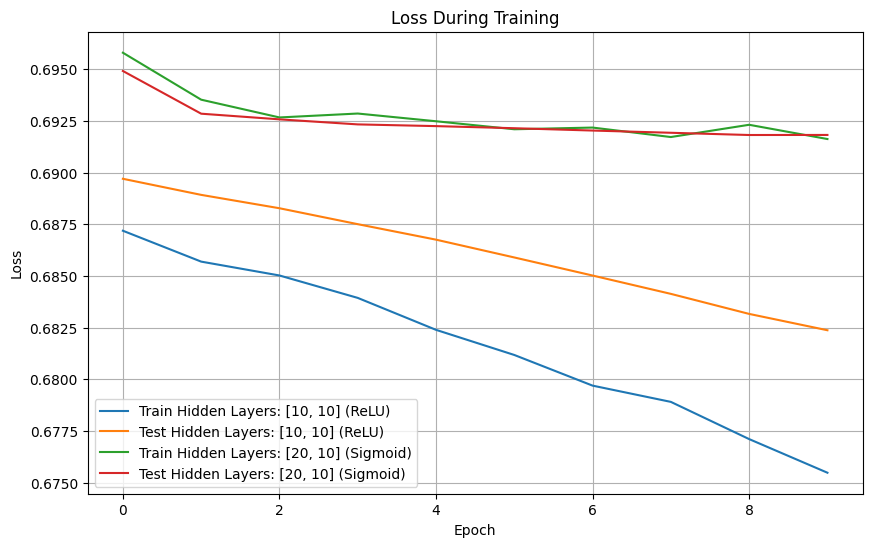

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

class MLPClassifierPyTorch(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation="relu"):
        super(MLPClassifierPyTorch, self).__init__()
        layers = []
        all_sizes = [input_size] + hidden_sizes + [output_size]

        for i in range(len(all_sizes) - 1):
            layers.append(nn.Linear(all_sizes[i], all_sizes[i + 1]))
            if i < len(all_sizes) - 2:
                if activation == "relu":
                    layers.append(nn.ReLU())
                elif activation == "sigmoid":
                    layers.append(nn.Sigmoid())

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


def calculate_accuracy(outputs, labels):
    """Calculate classification accuracy."""
    predictions = (torch.sigmoid(outputs) > 0.5).float()
    correct = (predictions == labels).sum().item()
    return correct / len(labels)


def train_model(model, train_loader, test_loader, epochs, criterion, optimizer, device):
    model.to(device)

    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0, 0

        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(x_batch).squeeze()
            loss = criterion(outputs, y_batch.float().squeeze())  # Ensure shapes are aligned
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_correct += calculate_accuracy(outputs, y_batch.squeeze()) * len(y_batch)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_correct / len(train_loader.dataset))

        model.eval()
        test_loss, test_correct = 0, 0

        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                outputs = model(x_batch).squeeze()
                loss = criterion(outputs, y_batch.float().squeeze())  # Ensure shapes are aligned
                test_loss += loss.item()
                test_correct += calculate_accuracy(outputs, y_batch.squeeze()) * len(y_batch)

        test_losses.append(test_loss / len(test_loader))
        test_accuracies.append(test_correct / len(test_loader.dataset))

        print(
            f"Epoch {epoch + 1}/{epochs} - Train Loss: {train_losses[-1]:.4f}, "
            f"Test Loss: {test_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, "
            f"Test Acc: {test_accuracies[-1]:.4f}"
        )

    # Return losses and final accuracies
    return train_losses, test_losses, train_accuracies[-1], test_accuracies[-1]


def plot_metrics(metrics, architectures, metric_name, ylabel):
    """Plot the given metrics for all architectures."""
    plt.figure(figsize=(10, 6))
    for i, (train_metric, test_metric) in enumerate(metrics):
        plt.plot(train_metric, label=f"Train {architectures[i]}")
        plt.plot(test_metric, label=f"Test {architectures[i]}")
    plt.title(f"{metric_name} During Training")
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid()
    plt.show()


if __name__ == "__main__":
    # Define paths and data loaders
    # Note: Implement `load_and_normalize_data` and `download_file_from_google_drive`
    file_id = '1Bkwa-QNG3pmI5ERcHLSIBLIglQYJXxTk'
    destination = 'classification.h5'
    download_file_from_google_drive(file_id, destination)

    x_train, y_train, x_test, y_test = load_and_normalize_data(destination)

    x_train = torch.tensor(x_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    x_test = torch.tensor(x_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    train_dataset = TensorDataset(x_train, y_train)
    test_dataset = TensorDataset(x_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    architectures = [
        "Hidden Layers: [10, 10] (ReLU)",
        "Hidden Layers: [20, 10] (Sigmoid)"
    ]

    metrics = []
    epochs = 10
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Train model with [10, 10] using ReLU
    model_relu = MLPClassifierPyTorch(input_size=2, hidden_sizes=[10, 10], output_size=1, activation="relu")
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model_relu.parameters(), lr=1e-3)

    train_losses_relu, test_losses_relu, final_train_acc_relu, final_test_acc_relu = train_model(
        model_relu, train_loader, test_loader, epochs, criterion, optimizer, device
    )
    metrics.append((train_losses_relu, test_losses_relu))

    print(f"Final Train Accuracy for [10, 10] (ReLU): {final_train_acc_relu * 100:.2f}%")
    print(f"Final Test Accuracy for [10, 10] (ReLU): {final_test_acc_relu * 100:.2f}%")

    # Train model with [20, 10] using Sigmoid
    model_sigmoid = MLPClassifierPyTorch(input_size=2, hidden_sizes=[20, 10], output_size=1, activation="sigmoid")
    optimizer = optim.Adam(model_sigmoid.parameters(), lr=1e-3)

    train_losses_sigmoid, test_losses_sigmoid, final_train_acc_sigmoid, final_test_acc_sigmoid = train_model(
        model_sigmoid, train_loader, test_loader, epochs, criterion, optimizer, device
    )
    metrics.append((train_losses_sigmoid, test_losses_sigmoid))

    print(f"Final Train Accuracy for [20, 10] (Sigmoid): {final_train_acc_sigmoid * 100:.2f}%")
    print(f"Final Test Accuracy for [20, 10] (Sigmoid): {final_test_acc_sigmoid * 100:.2f}%")

    # Plot losses
    plot_metrics(metrics, architectures, "Loss", "Loss")


### Subtask 4, Explanation:-

### **Classification Accuracy Observations:**

#### **[10, 10] Architecture (ReLU Activation):**
- **Training Accuracy:**
  - Starts at **50.80%** (Epoch 1) and improves steadily to **62.60%** (Epoch 10).
- **Testing Accuracy:**
  - Starts at **53.20%** (Epoch 1) and increases to **56.09%** (Epoch 10).
- **Performance Difference:**
  - Training accuracy is consistently higher than testing accuracy (by ~6.5% at the end), suggesting the model learns better on training data but slightly overfits to it.

#### **[20, 10] Architecture (Sigmoid Activation):**
- **Training Accuracy:**
  - Remains stagnant at ~**51.20%** across all epochs.
- **Testing Accuracy:**
  - Similarly flat at **51.58%** for all epochs.
- **Performance Difference:**
  - No significant difference between training and testing accuracies, indicating the model is struggling to learn meaningful patterns and barely improving beyond random guessing.

---

### **Key Observations:**

#### **1. Learning Behavior:**
- The `[10, 10]` architecture with **ReLU activation** shows a clear improvement in both training and testing accuracy over epochs, demonstrating that ReLU effectively facilitates learning by mitigating the vanishing gradient issue.
- The `[20, 10]` architecture with **Sigmoid activation** fails to learn effectively. The accuracies are flat, which is a symptom of the **vanishing gradient problem**, especially with deeper architectures.

#### **2. Generalization:**
- The `[10, 10]` architecture with ReLU shows moderate overfitting (train-test accuracy gap ~6.5%), which can be mitigated with regularization techniques (e.g., dropout or weight decay).
- The `[20, 10]` architecture with Sigmoid shows no significant overfitting, but this is because the model is not learning meaningful patterns in the first place.

#### **3. Impact of Activation Functions:**
- **ReLU**:
  - Allows the model to learn effectively by avoiding the vanishing gradient issue and enabling faster convergence.
- **Sigmoid**:
  - Poor performance due to its squashing behavior, which diminishes gradients and hampers learning, especially in deeper networks.

---

### **Differences in Performance:**
- The `[10, 10]` architecture with ReLU clearly outperforms `[20, 10]` with Sigmoid in terms of training and testing accuracies.
- ReLU supports effective learning and generalization, while Sigmoid leads to learning stagnation in deeper architectures.

---

### **Conclusion:**
- The choice of activation function has a profound impact on learning. ReLU is more suitable for deeper networks and modern architectures.
- The `[10, 10]` architecture is better suited for the task and can be further improved with regularization and additional training.  
- The `[20, 10]` architecture requires a switch to a modern activation function (e.g., ReLU or Leaky ReLU) to address its learning issues.

---

The primary difference between custom neural networks and PyTorch-based models lies in their predictability and performance. Custom neural networks often exhibit unpredictable learning behavior; sometimes they perform well, but other times the accuracy does not exceed 49%. In contrast, PyTorch-based models are highly reliable during training, consistently achieving accuracies of over 50%.

---